# Oscilladar

We will make two classes: neurons and synapses

Each neuron has its value and its error, that will be clculated each time an example is presented.

Each slayer (= __s__ynapses __layer__) is a list of pairs - the synapses.

Synapse objects will hold the neurons (by name).


for each layer, we will loop over the NEURONS, determinig their value by summing with a tanh as the activation function.

Then, we will calculate the error for each layer and update the synapse values with them.


We will loop over each layer, adding the weight*pre-value for each post. (with tanh(), like in the booklet)

The value of neurons will be 0 when starting the run each time, but synapses will stay and be modified.



In [1]:
# here we will create the neuron objects

class neuron:
    def __init__(self):
        self.value = 0
        self.error = 0
        

In [2]:
# here we will create the synapse objects 
# each will have its weight, and its pre- and post-synaptic neurons as NAMES - strings.
# that way, we will access a neuron on the layer dict by its name.

import numpy.random as r

class synapse:
    def __init__(self,pre,post):
        self.pre = pre
        self.weight = r.random()
        self.post = post
        

In [3]:
# here we will create the layer object

class nlayer:
    def __init__(self,size):
        self.members = {}
        for i in range(size):
            self.members['n'+str(i+1)] = neuron()
    
    def get_neurons(self):
        return self.members
    
class slayer:
    def __init__(self,s_list):
        self.pairs = []
        for pair in s_list:
            self.pairs += [synapse(pair[0],pair[1])]
            
    def get_synapses(self):
        return self.pairs
        
        

In [4]:
# here we will create the network object
beta = 3

class network:
    def __init__(self,path):
        self.nlayers = {}
        n_counter = 0
        self.slayers = {}
        s_counter = 0
        to_s = []
        with open(path) as f:
            lines = f.readlines()
        for line in lines:
            line = line[:-1] # to delete the '\n'
            if line.isdigit():
                if to_s != []:
                    self.slayers['synapses'+str(s_counter)] = slayer(to_s)
                    s_counter+=1
                    to_s = []
                self.nlayers['layer'+str(n_counter)] = nlayer(int(line))
                n_counter+=1
                
            else:
                to_s += [line.split()]

        self.slayers['synapses'+str(s_counter)] = slayer(to_s)
        s_counter+=1
        to_s = []
                
        self.nlayers['output'] = nlayer(1)
    
    def get_nlayers(self):
        return self.nlayers
    
    def get_slayers(self):
        return self.slayers
    
    def add_layer(self,size):
        ind = len(self.members)-1
        self.members['layer '+str(ind)] = layer(size)
        
    def clear_nlayers(self):
        for nlayer in self.nlayers.values():
            ns = nlayer.get_neurons()
            for name in ns:
                ns[name].value = 0
                ns[name].error = 0
        
    def cal_neurons(self,example):
        import numpy as np
        
        y0 = example['class']
        pat = np.reshape(example['pattern'],(example['pattern'].size))
        
        self.clear_nlayers()
        
        nlayers = self.get_nlayers()
        
        # present to the network
        i = 0
        for ni in nlayers['layer0'].get_neurons().values():
            ni.value = pat[i]
            i+=1
       
        # calculate the neurons values in each layer
        
        for name,slayer in self.slayers.items():
            pre_layer = self.nlayers['layer'+name[-1]].get_neurons()

            post_layer_name = 'layer'+str(int(name[-1])+1) 
            post_layer_name = post_layer_name if post_layer_name in self.nlayers else 'output'
            post_layer = self.nlayers[post_layer_name].get_neurons()
            
            for synapse in slayer.get_synapses():
                post_layer[synapse.post].value += pre_layer[synapse.pre].value*synapse.weight
            
            for neuron in post_layer.values():
                neuron.value = np.tanh(beta*neuron.value)
        
        # calculate the error for each layer
        re_slayers = reversed(list(self.get_slayers().keys()))
        output_n = self.get_nlayers()['output'].get_neurons()['n1']
        output_n.error = beta*(1-output_n.value**2)*(y0 - output_n.value)
        
        for slayer_name in re_slayers:
            pre_layer_name = 'layer'+slayer_name[-1]
            pre_layer = self.nlayers[pre_layer_name].get_neurons()
            
            post_layer_name = 'layer'+str(int(slayer_name[-1])+1) 
            post_layer_name = post_layer_name if post_layer_name in self.nlayers else 'output'
            post_layer = self.nlayers[post_layer_name].get_neurons()
            
            for synapse in self.slayers[slayer_name].get_synapses():
                pre_layer[synapse.pre].error += post_layer[synapse.post].error*synapse.weight
                
            for neuron in pre_layer.values():
                neuron.error = neuron.error*beta*(1-(neuron.value)**2)
                
                
        # update the weights
        eta = 0.1
        
        for name,slayer in self.slayers.items():
            pre_layer_name = 'layer'+name[-1]
            pre_layer = self.nlayers[pre_layer_name].get_neurons()

            post_layer_name = 'layer'+str(int(name[-1])+1) 
            post_layer_name = post_layer_name if post_layer_name in self.nlayers else 'output'
            post_layer = self.nlayers[post_layer_name].get_neurons()
            
            for synapse in slayer.get_synapses():
                synapse.weight += eta * post_layer[synapse.post].error * pre_layer[synapse.pre].value
            
        return self.nlayers['output'].get_neurons()['n1'].value
                     
        
        
        

In [5]:
class network(network):
    def classify(self,example):
        import numpy as np
        
        pat = np.reshape(example['pattern'],(example['pattern'].size))
        
        self.clear_nlayers()
        
        nlayers = self.get_nlayers()
        
        # present to the network
        i = 0
        for ni in nlayers['layer0'].get_neurons().values():
            ni.value = pat[i]
            i+=1
       
        # calculate the neurons values in each layer
        for name,slayer in self.slayers.items():
            pre_layer = self.nlayers['layer'+name[-1]].get_neurons()

            post_layer_name = 'layer'+str(int(name[-1])+1) 
            post_layer_name = post_layer_name if post_layer_name in self.nlayers else 'output'
            post_layer = self.nlayers[post_layer_name].get_neurons()
            
            for synapse in slayer.get_synapses():
                post_layer[synapse.post].value += pre_layer[synapse.pre].value*synapse.weight
            
            for neuron in post_layer.values():
                neuron.value = np.tanh(beta*neuron.value)
                
        return nlayers['output'].get_neurons()['n1'].value
        

In [6]:
import joblib
train = joblib.load(r'C:\Users\mimis\Desktop\patterns wiki\new_ts.pkl') 
res = joblib.load(r'C:\Users\mimis\Desktop\patterns wiki\new_ts-1.pkl') 

In [7]:
train += res

In [8]:
import random
import copy

s = copy.deepcopy(train)

random.shuffle(s)

cut = 217
test = s[:cut]
training = s[cut:]

In [9]:
net = network(r"C:\Users\mimis\Documents\_Semesters\2022א\חישוביות ביולוגית-4מ\mmn 13\MINE\network5.txt")
test_acc = []
train_acc = []

In [10]:
before = []
for t in test:
    before += [net.classify(t)]
    
aha = [int(round(before[i]))-test[i]['class'] for i in range(len(before))]
bum = [sum(1 for x in aha if x==0)/len(aha)]

In [24]:
import numpy as np
import datetime

print(datetime.datetime.now())


for i in range(10):
    random.shuffle(training)
    train_error = [int(round(net.cal_neurons(t)))-t['class'] for t in training]
    train_acc += [sum(1 for x in train_error if x==0)/len(train_error)]

    
    test_error = [int(round(net.classify(t)))-t['class'] for t in test]
    test_acc += [sum(1 for x in test_error if x==0)/len(test_error)]
    
print(datetime.datetime.now())


2022-01-24 11:10:36.807324
2022-01-24 11:12:01.012118


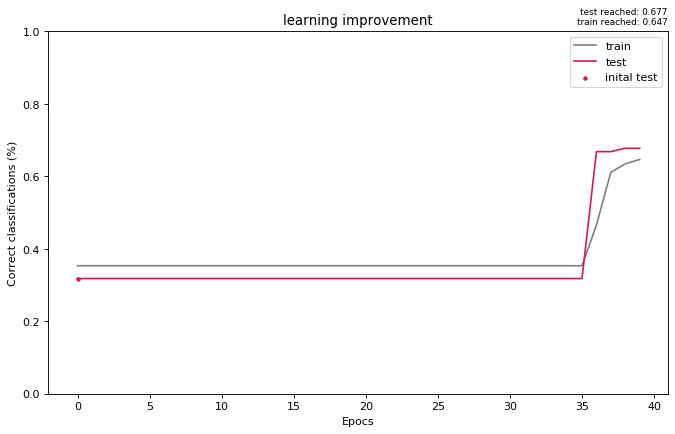

In [26]:
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    from matplotlib.pyplot import figure

    figure(figsize=(10, 6), dpi=80)

    plt.plot(train_acc[:40],label='train',c='gray')
    plt.plot(test_acc[:40],label='test',c='#d11d53')
    
    plt.title('test reached: '+str(round((test_acc[39]),3))+'\ntrain reached: '+str(round((train_acc[39]),3)),loc='right',fontsize=8)
    plt.title("learning improvement")
    plt.ylabel("Correct classifications (%)")
    plt.xlabel("Epocs")
    

    plt.scatter(0,bum,c='#d11d53',label='inital test',marker='.')
    
#     plt.arrow(8, 0.45, 1, 0.13, width = 0.001)
#     plt.text(6, 0.35, 'here, we shuffled\nthe training set', fontsize = 8)
#     plt.arrow(58, 0.51, 1.5, 0.15, width = 0.001)
#     plt.text(54, 0.43, 'here, we mutated\nthe training set\nwith p=0.001', fontsize = 8)
#     plt.arrow(29, 0.55, 2, 0.1, width = 0.001)
#     plt.text(27, 0.45, 'started mutating\neach epoc', fontsize = 8)
#     plt.arrow(39, 0.55, 2, 0.1, width = 0.001)
#     plt.text(37, 0.45, 'stopped mutating\neach epoc', fontsize = 8)
    
    ax = plt.gca()
    ax.set_ylim([0, 1])
    
    plt.legend()
    plt.show()

In [13]:
def mutate(ds):
    pm = 0.001
    train = copy.deepcopy(ds)

    for t in train:
        for i in range(25):
            for j in range(25):
                if np.random.random() < pm:
                    t['pattern'][i][j] = 1-t['pattern'][i][j]
    return train
            

In [14]:
import copy
training_orig = copy.deepcopy(training)
training = mutate(training)